In [2]:
import os
from typing import TypedDict, List, Optional, Annotated
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import Docx2txtLoader
from dotenv import load_dotenv
import docx2txt  # Fallback processor


In [3]:
# Load environment variables (for LLM API keys)
load_dotenv()

True

In [4]:
# Define State
class AgentState(TypedDict):
    conversation_history: Annotated[List[dict], lambda a, b: a + b]
    test_report_text: Optional[str]
    task_progress: Annotated[dict, lambda a, b: {**a, **b}]
    current_questions: Annotated[List[str], lambda a, b: a + b]

# Initialize state
initial_state = AgentState({
    "conversation_history": [],
    "test_report_text": None,
    "task_progress": {},
    "current_questions": []
})

In [5]:
# Define Nodes
def collect_symptoms(state: AgentState):
    """Collect patient symptoms through conversation"""
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_openai import ChatOpenAI
    
    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o-mini")
    
    # Generate next question
    if not state["current_questions"]:
        prompt = ChatPromptTemplate.from_template(
            "Start a conversation to collect patient symptoms. Ask one clear question."
        )
        question = llm.invoke(prompt.format()).content
    else:
        question = state["current_questions"].pop(0)
    
    # Simulate user input
    print(f"[Assistant] {question}")
    user_input = input("[Patient] ")
    
    return {
        "conversation_history": [
            {"role": "assistant", "content": question},
            {"role": "user", "content": user_input}
        ],
        "current_questions": []
    }


In [6]:
def process_report(state: AgentState):
    """Process uploaded DOCX report"""
    try:
        # Use LangChain's DOCX loader
        loader = Docx2txtLoader("temp_report.docx")
        docs = loader.load()
        report_text = "\n".join([doc.page_content for doc in docs])
    except Exception as e:
        # Fallback processing
        report_text = docx2txt.process("temp_report.docx")
    
    return {"test_report_text": report_text}


In [8]:
def generate_confirmation_questions(state: AgentState):
    """Generate questions to confirm test report findings"""
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_openai import ChatOpenAI
    
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = ChatPromptTemplate.from_template("""
    Generate 3 questions to confirm consistency between these symptoms:
    {symptoms}
    
    And this test report:
    {report}
    
    Return questions as bullet points.
    """)
    
    chain = prompt | llm
    questions = chain.invoke({
        "symptoms": state["conversation_history"],
        "report": state["test_report_text"]
    }).content
    
    return {"current_questions": [q.strip() for q in questions.split("\n") if q.strip()]}


In [9]:
def answer_report_queries(state: AgentState):
    """Answer patient questions about their report"""
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_openai import ChatOpenAI
    
    print("Ask about your test report (type 'done' to finish):")
    while True:
        user_input = input("[Patient Question] ")
        if user_input.lower() == 'done':
            break
            
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = ChatPromptTemplate.from_template("""
        Answer this question about the test report:
        Question: {question}
        
        Report Content:
        {report}
        
        Keep answers professional but patient-friendly.
        """)
        
        chain = prompt | llm
        answer = chain.invoke({
            "question": user_input,
            "report": state["test_report_text"]
        }).content
        
        print(f"[Assistant] {answer}")
        
    return {"conversation_history": []}

In [10]:
def generate_summary(state: AgentState):
    """Generate final summary for doctor"""
    from langchain_core.prompts import ChatPromptTemplate
    from langchain_openai import ChatOpenAI
    
    llm = ChatOpenAI(model="gpt-4")
    prompt = ChatPromptTemplate.from_template("""
    Create a medical summary for a doctor containing:
    1. Patient symptoms
    2. Test report highlights
    3. Key conversation points
    4. Recommended next steps
    
    Conversation History:
    {history}
    
    Test Report:
    {report}
    """)
    
    chain = prompt | llm
    summary = chain.invoke({
        "history": state["conversation_history"],
        "report": state["test_report_text"]
    }).content
    
    print(f"\n[Doctor Summary]\n{summary}")
    return {"task_progress": {"summary_generated": True}}

In [11]:
# Create workflow
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("collect_symptoms", collect_symptoms)
workflow.add_node("process_report", process_report)
workflow.add_node("generate_confirmation", generate_confirmation_questions)
workflow.add_node("answer_questions", answer_report_queries)
workflow.add_node("generate_summary", generate_summary)

# Set up edges
workflow.set_entry_point("collect_symptoms")

workflow.add_edge("collect_symptoms", "process_report")
workflow.add_conditional_edges(
    "process_report",
    lambda state: "generate_confirmation" if state["test_report_text"] else "collect_symptoms",
    {
        "generate_confirmation": "generate_confirmation",
        "collect_symptoms": "collect_symptoms"
    }
)
workflow.add_edge("generate_confirmation", "answer_questions")
workflow.add_edge("answer_questions", "generate_summary")
workflow.add_edge("generate_summary", END)

# Compile the workflow
app = workflow.compile()

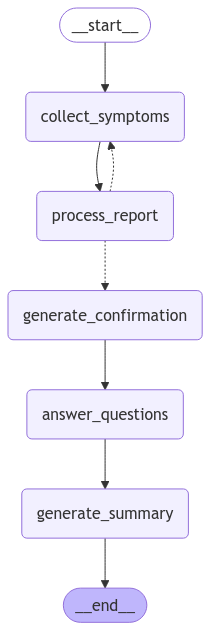

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [ ]:
# Run the system
def run_system():
    # Simulate document upload
    if os.path.exists("temp_report.docx"):
        os.remove("temp_report.docx")
        
    # For demo purposes, create a sample DOCX file
    from docx import Document
    doc = Document()
    doc.add_paragraph("Patient Test Report\n\nBlood Pressure: 120/80\nCholesterol: 200 mg/dL\nNotes: Elevated white blood cell count")
    doc.save("temp_report.docx")
    
    # Initialize and run
    response = app.invoke(initial_state)
    return response

if __name__ == "__main__":
    run_system()

[Assistant] Sure! To begin, can you tell me what symptoms you're currently experiencing?
Ask about your test report (type 'done' to finish):
[Assistant] Based on the test report provided, here are some insights:

- **Blood Pressure**: Your blood pressure reading of 120/80 mm Hg is considered within the normal range, indicating good cardiovascular health.

- **Cholesterol**: Your cholesterol level is recorded at 200 mg/dL. While this reading is the threshold for borderline high cholesterol, it’s advisable to monitor your cholesterol levels regularly and discuss with your healthcare provider any necessary lifestyle changes or further testing.

- **Elevated White Blood Cell Count**: The elevated white blood cell count may indicate an underlying condition, such as an infection or inflammation. It would be beneficial to follow up with your physician to understand the implications and necessary next steps.

Overall, it’s important to keep a close dialogue with your healthcare provider about 